In [22]:
# Basic librairies (all the librairies used for the machine learning are imported in the tools.py file)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.pipeline import Pipeline

from warnings import filterwarnings

from pmdarima.utils import tsdisplay
filterwarnings('ignore')

In [20]:
# Import all functions we build to process our predictions. All the functions are in the DreamLib folder
from DreamLib.processing_datas import *
from DreamLib.timeseries import *
import datas.selected_columns as cl

In [21]:
# Data importation
data = pd.read_sas("datas/total_red.sas7bdat")
# Useful to plot the model 
index = data.set_index('TRIMESTRE').index.unique()

# Functions

### General

In [17]:
dft = data[data.CHRONIQUE == b'Totale']
dft.set_index(dft.TRIMESTRE,inplace=True)

Yt = dft['DR']

dft = dft.drop(['DR','TRIMESTRE','CHRONIQUE','dtf_per_trt'],axis = 1)

# we assure the type float of our variables
df = dft.astype('float64', copy=True)
y = Yt.astype('float64', copy=True)

We need to clean the data, normalize it in order to prepare it for X_train, X_test, y_train and y_test. Then we plot the evolution of the variable that we need to predict.

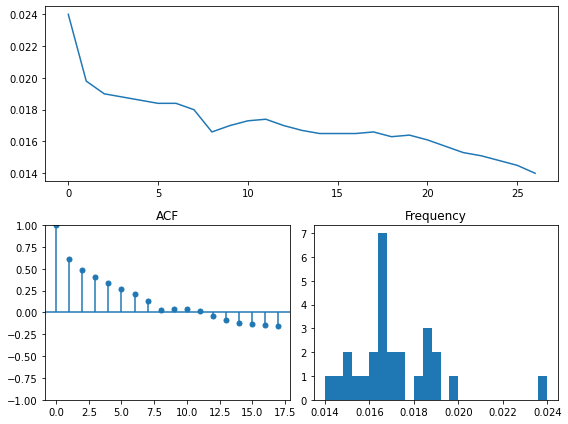

In [19]:
start=0
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_corr,split=0.2,norm='Not')
tsdisplay(y_train, lag_max=17)

The we find the best Arima model to predict the default rate. And we obtain all statistics linked to our model.

In [9]:
fit1 = pm.auto_arima(y_train, m=12, trace=True, suppress_warnings=True)
fit1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-75.916, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-72.551, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-69.662, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-66.937, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-73.916, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-73.916, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-71.916, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-74.551, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-71.662, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-71.172, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.632 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   20
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                  39.958
Date:                  Tue, 06 Dec 2022   AIC                            -75.916
Time:                          23:16:17   BIC                            -75.757
Sample:                      12-31-2008   HQIC                           -76.988
                           - 09-30-2013                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0028      0.002     -1.590      0.112      -0.006       0.001
sigma2      2.686e-06   2.77e-06      0.971      0.331   -2.73e-06    8.11e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 7.14
Prob(Q):                              0.53   Prob(JB):                         0.03
Heteroskedasticity (H):               0.17   Skew:                            -1.98
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can also apply the Box Cox Transformation to an non normal endogenous array in order to coerce it more towards a normal distribution. Then we plot the time series

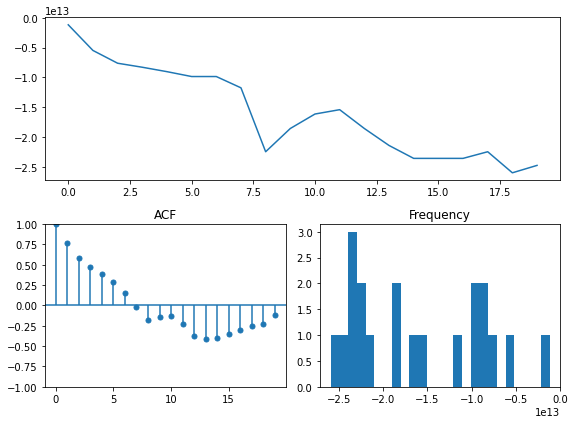

In [10]:
y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=19)

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. But now that the model is set up, we can use its fit() method to fit this model to data. And we can get all statistics linked to the model.

In [11]:
fit2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=12))
])

fit2.fit(y_train)
fit2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=475.564, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=474.560, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=475.677, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=514.979, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=477.839, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=475.417, Time=0.38 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=475.183, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=473.275, Time=0.06 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=475.066, Time=0.27 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=476.752, Time=0.24 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=476.830, Time=0.03 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=473.744, Time=0.25 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   20
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -232.637
Date:                              Tue, 06 Dec 2022   AIC                            473.275
Time:                                      23:16:19   BIC                            473.593
Sample:                                           0   HQIC                           471.132
                                               - 20                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.481e+13   2.51e-14   -5.9e+26      0.000   -1.48e+13   -1.48e+13
ar.L1         -0.1311      0.179     -0.732      0.464      -0.482       0.220
ma.S.L12      -0.4749      1.519     -0.313      0.755      -3.453       2.503
sigma2      1.815e+24   5.01e-25   3.62e+48      0.000    1.81e+24    1.81e+24
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.11   Prob(JB):                         0.92
Heteroskedasticity (H):              10.82   Skew:                             0.35
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.12e+64. Standard errors may be unstable.
"""

# Focus on chronique total

Then for chronique totale we will build and plot all models for each type of features selection.

In [12]:
start = 2

## With col_totale_corr

For the correlation feature selection we clean the data, build and find the best ARIMA model.

In [13]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_corr,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.



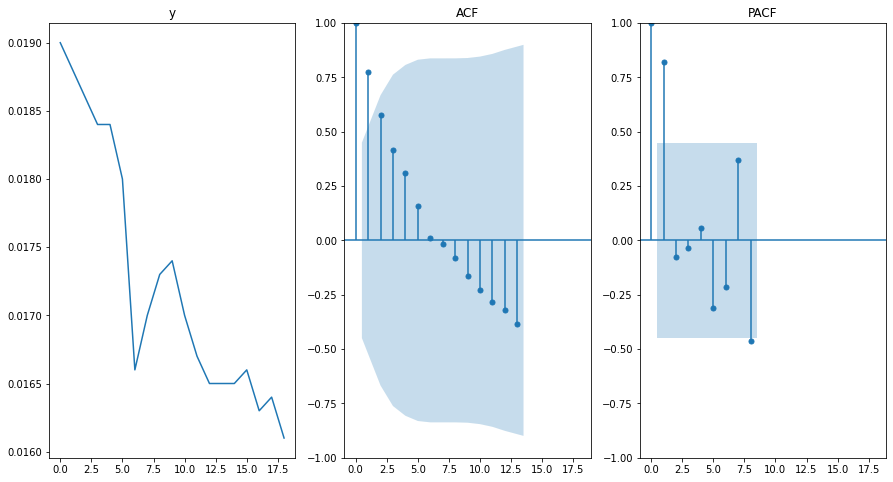

0

In [14]:
acf_pacf(y_train,alpha=0.05)


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-352.901, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-362.572, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-360.572, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-360.572, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-358.362, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-360.572, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.796 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:        

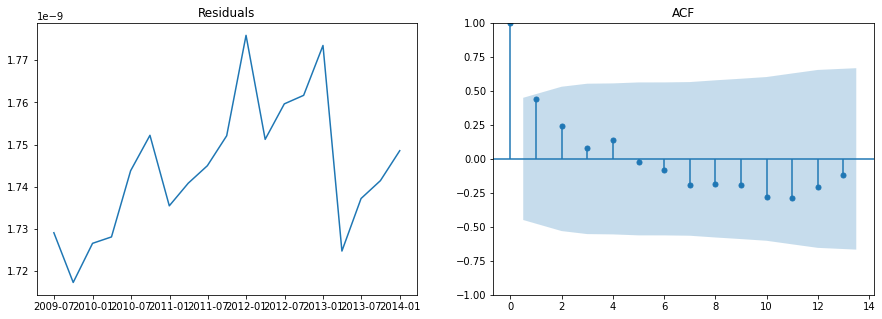


Test statistic for the residuals: -2.554
P-value for the residuals: 0.10285
The residuals are not stationary. We accept the hypothesis of a unit root.



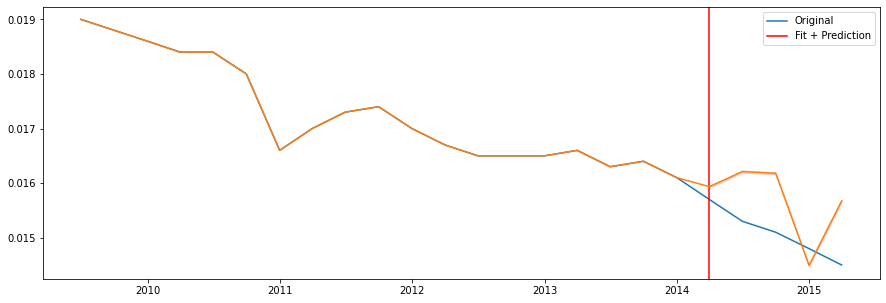

In [15]:
model = find_arimax_params(y_train,exog=X_train)
plot_arimax_fit(model,y_train,y_test=y_test,exog_train=X_train,exog_test=X_test)

The best model is :

$$
ARIMA(,,)
$$

## With col_totale_low_var

For the low variance feature selection we clean the data, build and find the best ARIMA model.

In [16]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_low_var,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-324.755, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-334.572, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-332.065, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-332.100, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-330.081, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-332.572, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.238 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:        

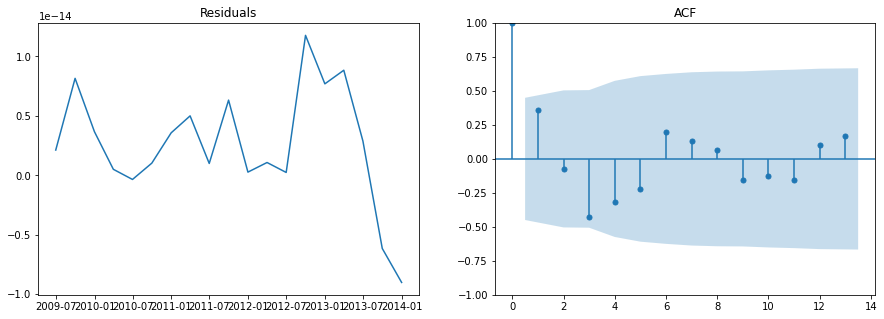


Test statistic for the residuals: -1.742
P-value for the residuals: 0.40967
The residuals are not stationary. We accept the hypothesis of a unit root.



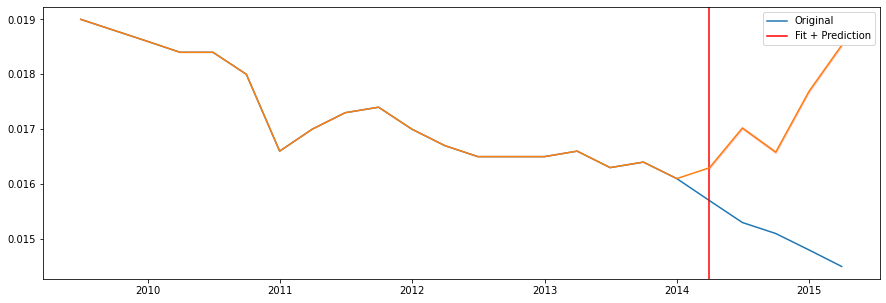

In [17]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

The best model is :

$$
ARIMA(,,)
$$

## With col_totale_kbest

For the kbest feature selection we clean the data, build and find the best ARIMA model.

In [18]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_kbest,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-349.640, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-360.572, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-357.724, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-358.541, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-355.501, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-358.572, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.794 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:        

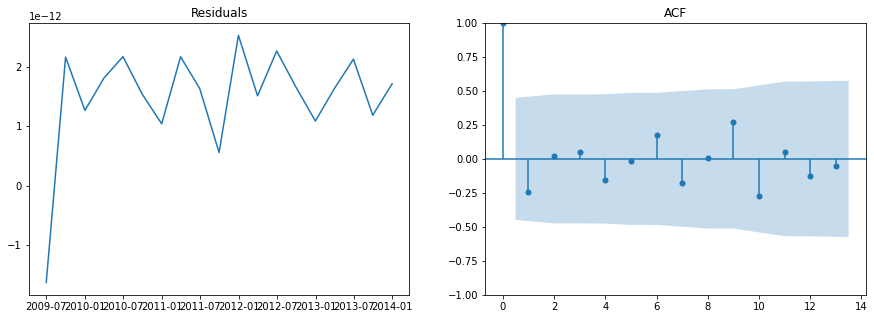


Test statistic for the residuals: -4.707
P-value for the residuals: 8e-05
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.



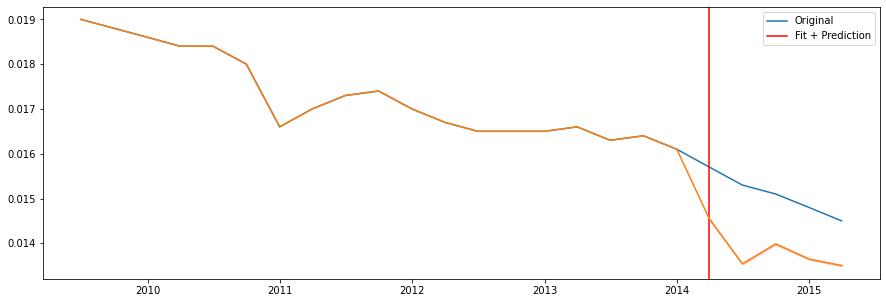

In [19]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

The best model is :

$$
ARIMA(,,)
$$

## With col_totale_recur

For the recursive feature selection we clean the data, build and find the best ARIMA model.

In [20]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_recur,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-340.572, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-348.572, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-346.572, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-346.563, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-344.076, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.954 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:              

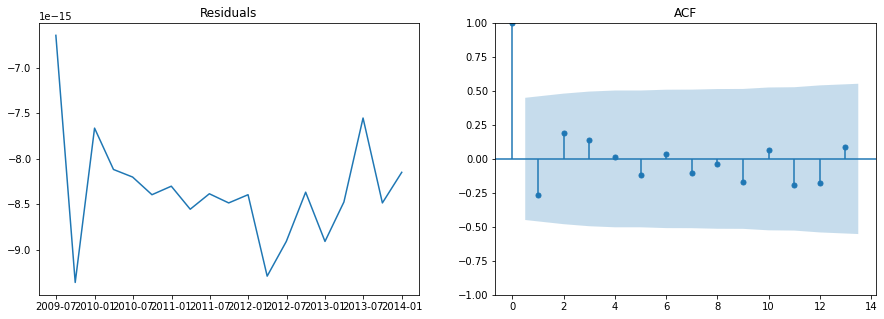


Test statistic for the residuals: -0.786
P-value for the residuals: 0.82315
The residuals are not stationary. We accept the hypothesis of a unit root.



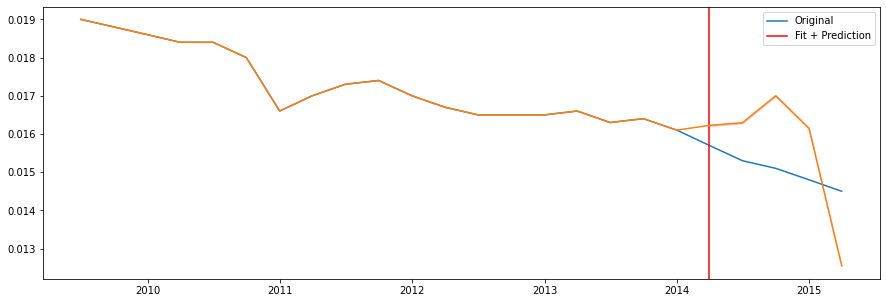

In [21]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

The best model is :

$$
ARIMA(,,)
$$

## With col_totale_sfm

For the select from model feature selection we clean the data, build and find the best ARIMA model.

In [22]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_sfm,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-270.735, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-260.881, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-304.391, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-311.371, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-308.480, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-295.357, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-280.808, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.206 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. 

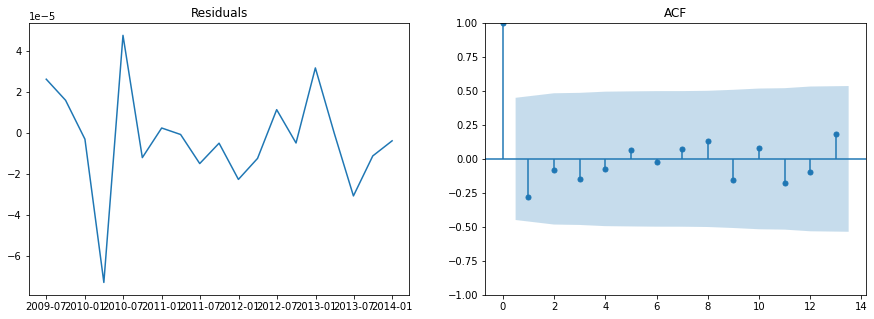


Test statistic for the residuals: -5.558
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.



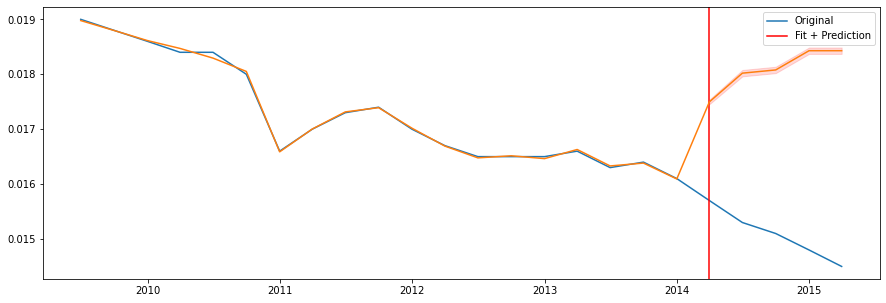

In [23]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_tree

For the tree-based feature selection we clean the data, build and find the best ARIMA model.

In [24]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_tree,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-336.794, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-352.572, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-349.480, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-350.279, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-346.639, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-350.572, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.165 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:        

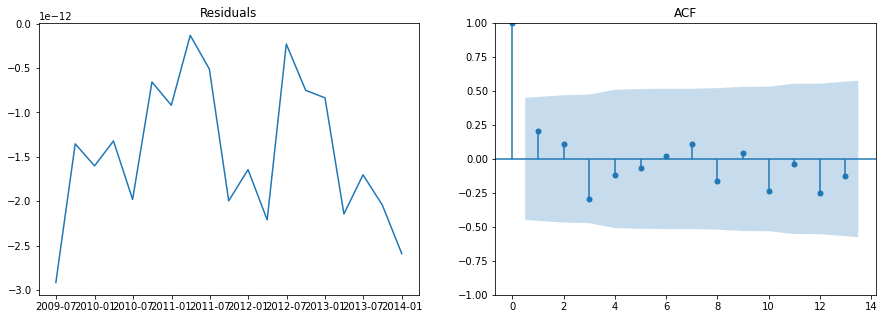


Test statistic for the residuals: -3.34
P-value for the residuals: 0.01318
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.



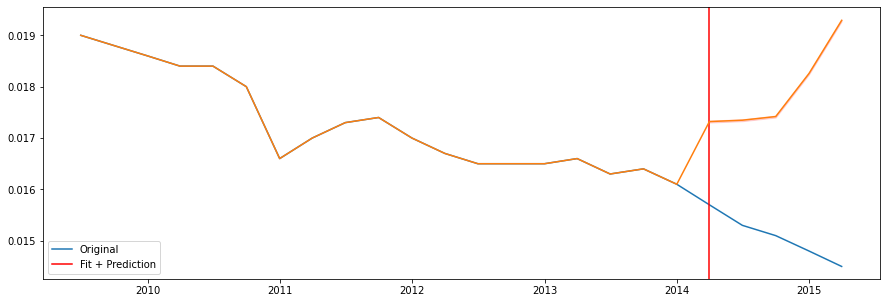

In [25]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_for

For the sequential feature selection we clean the data, build and find the best ARIMA model.

In [26]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_seq_for,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-216.033, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-189.988, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-226.227, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-227.370, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-204.437, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-229.474, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-227.066, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-204.751, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-204.831, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-227.918, Time=0.19 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 

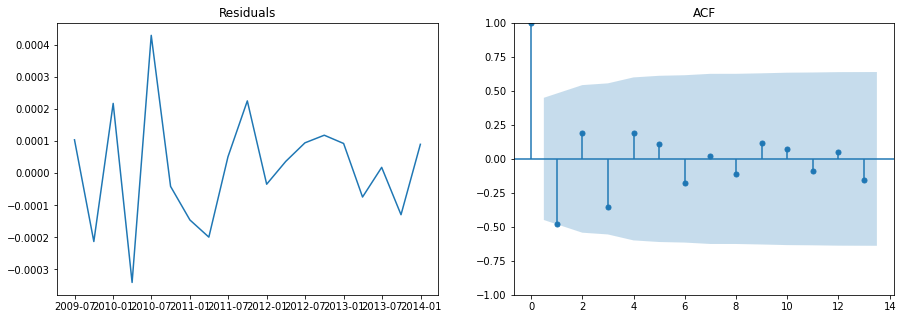


Test statistic for the residuals: -2.506
P-value for the residuals: 0.11392
The residuals are not stationary. We accept the hypothesis of a unit root.



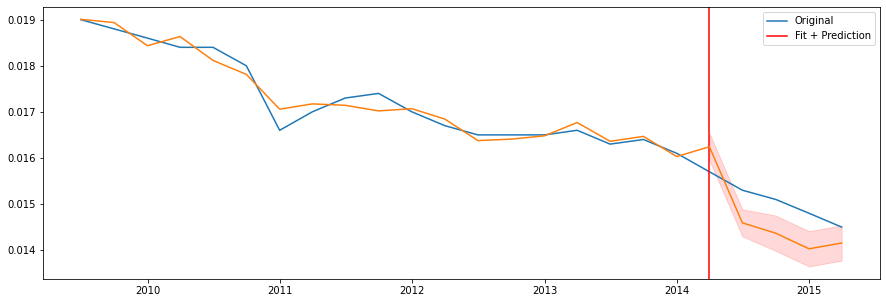

In [27]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_bac

For the backward feature selection we clean the data, build and find the best ARIMA model.

In [28]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"Totale",col_used=cl.col_totale_seq_bac,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y: -5.264
P-value for the series y: 1e-05
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-352.572, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-360.572, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-357.911, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-358.206, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-355.438, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-358.572, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.808 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 201.286
Date:        

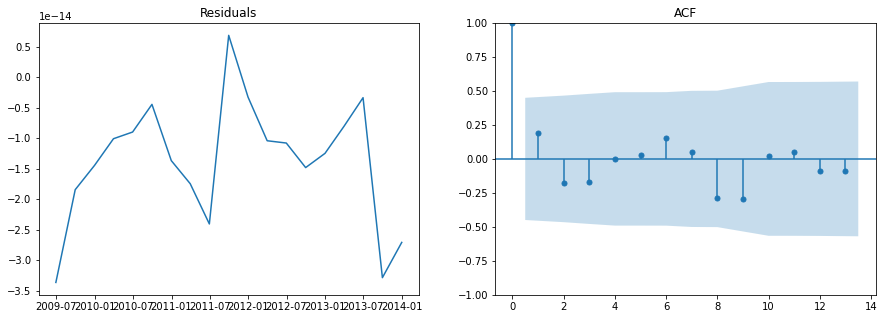


Test statistic for the residuals: -3.514
P-value for the residuals: 0.00764
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 0.



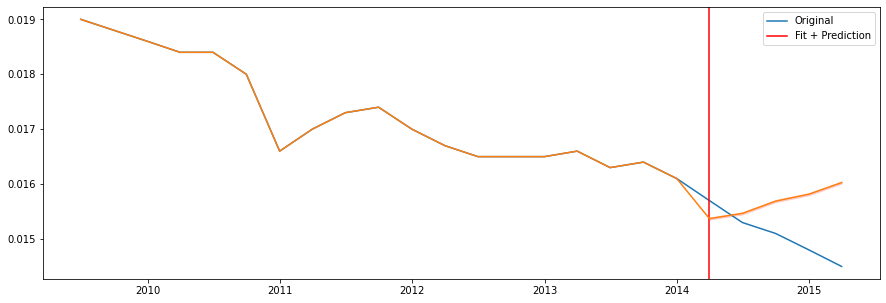

In [29]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

# Focus on chronique CHR2

Then for chronique CHR2 we will build and plot all models for each type of features selection.

In [30]:
start = 2

## With col_totale_corr

In [31]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_corr,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



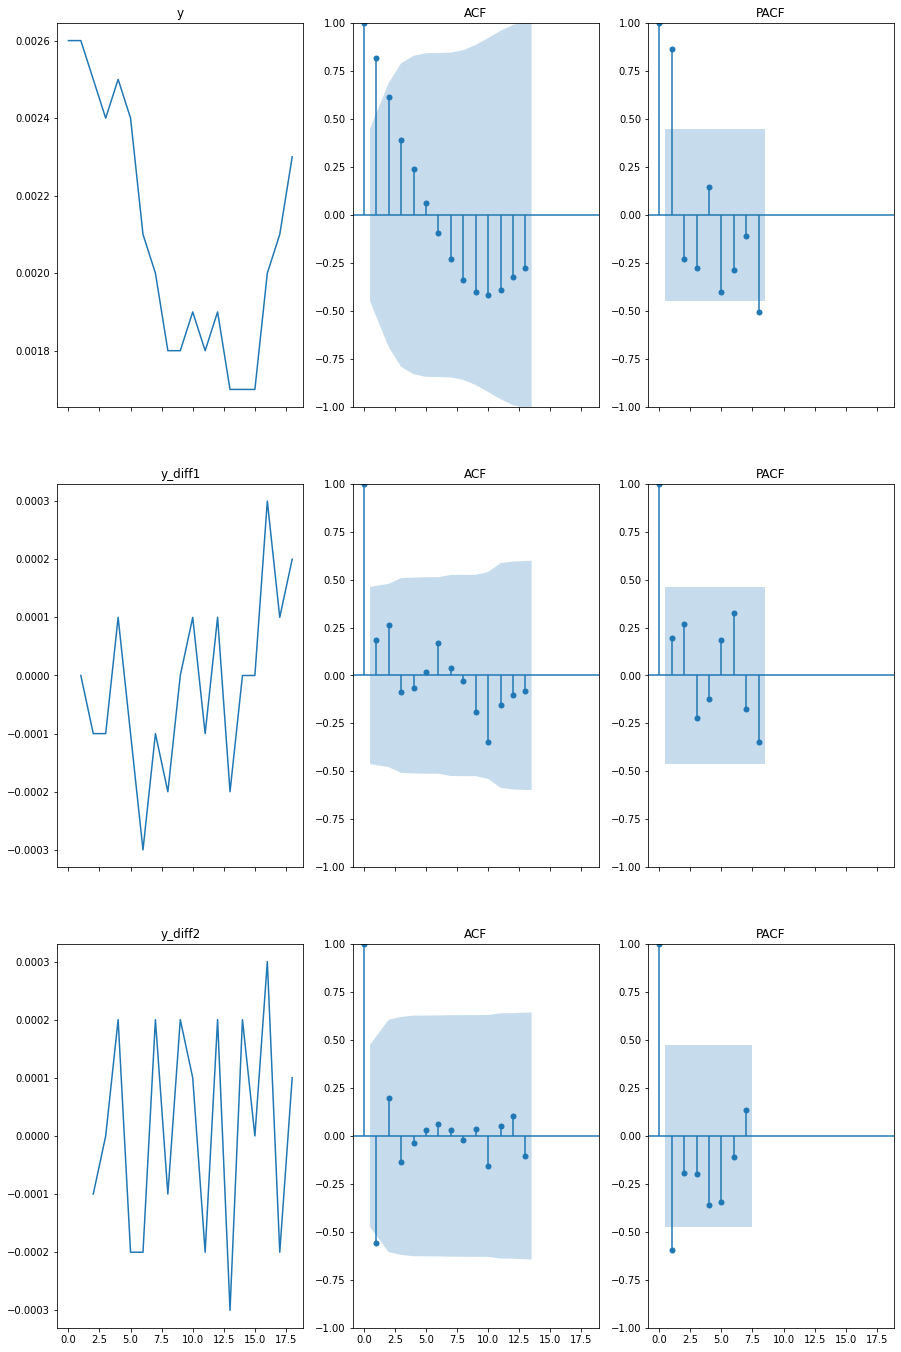

2

In [32]:
acf_pacf(y_train,alpha=0.05)


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-186.929, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-239.148, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-242.196, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-242.788, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-208.934, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-240.058, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-239.060, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-236.820, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-245.735, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-242.889, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-241.20

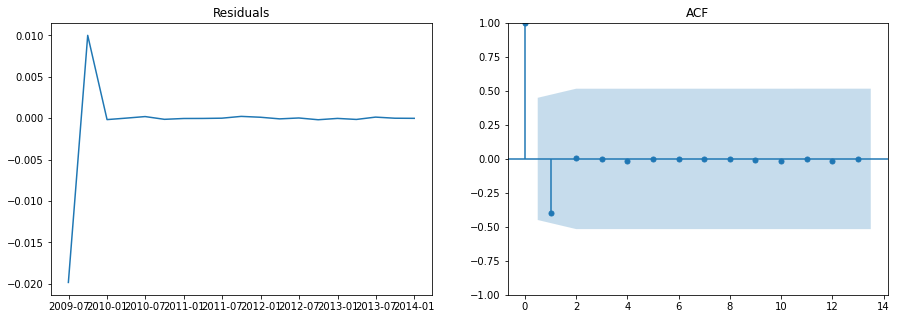


Test statistic for the residuals: -29.75
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



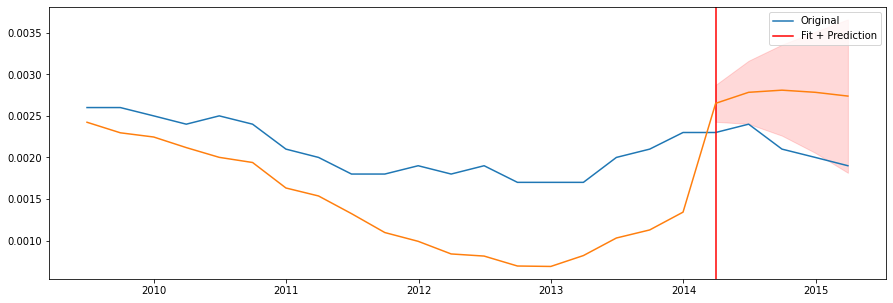

In [33]:
model = find_arimax_params(y_train,exog=X_train)
plot_arimax_fit(model,y_train,y_test=y_test,exog_train=X_train,exog_test=X_test)

## With col_totale_low_var

In [34]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_low_var,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-277.350, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-285.350, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-283.350, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-283.350, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-287.350, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-281.350, Time=0.29 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.482 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 179.675

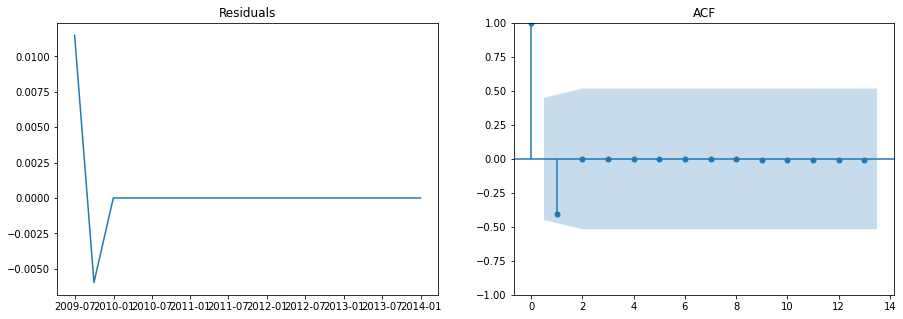


Test statistic for the residuals: -27.716
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



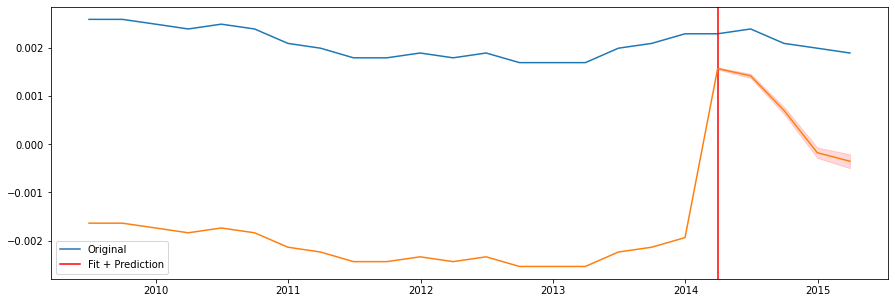

In [35]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_kbest

In [36]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_kbest,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-306.679, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-315.350, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-313.545, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-313.272, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-317.350, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-311.219, Time=0.19 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.908 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 179.675

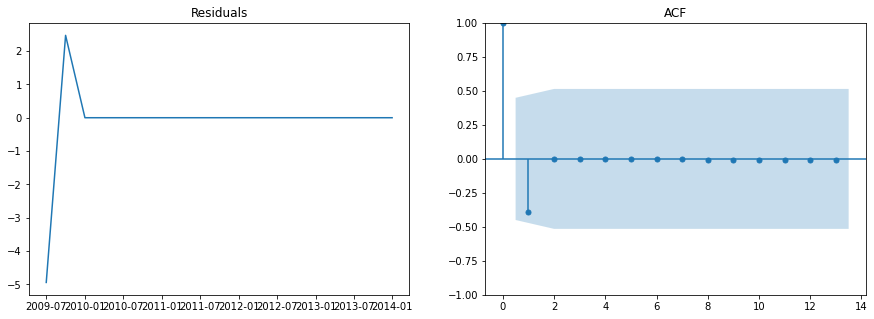


Test statistic for the residuals: -29.224
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



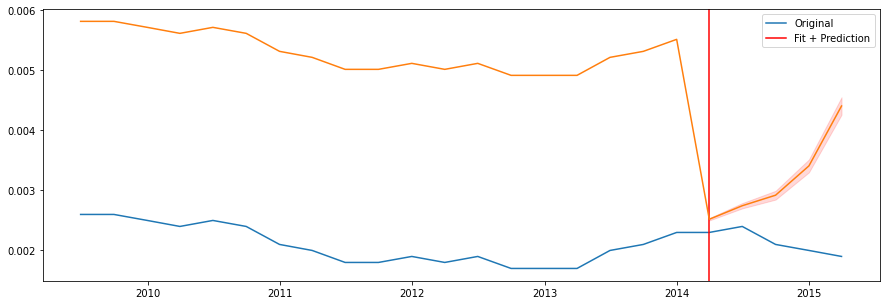

In [37]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_recur

In [38]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_recur,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-274.243, Time=1.38 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-286.977, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-285.971, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-288.631, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-289.539, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-287.399, Time=0.48 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 2.767 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 160.769

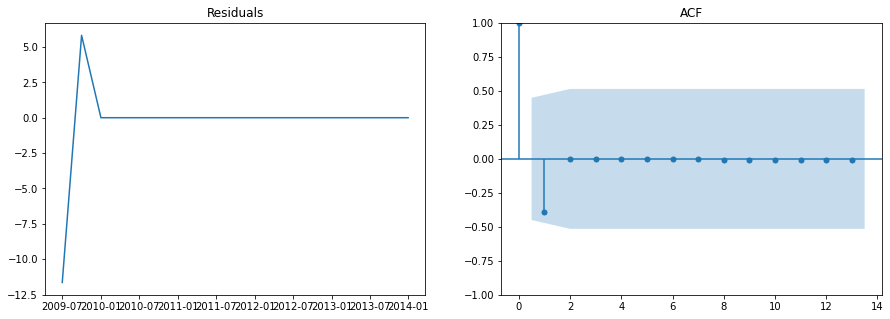


Test statistic for the residuals: -29.227
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



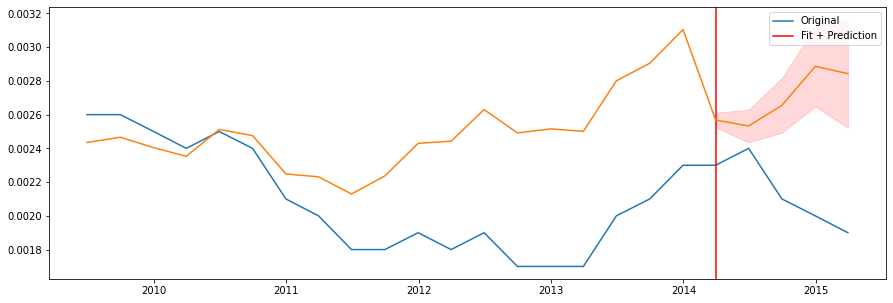

In [39]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_sfm

In [40]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_sfm,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-234.259, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-274.190, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-277.677, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-281.540, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-234.880, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-278.439, Time=0.42 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-269.836, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-267.590, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-258.639, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 1.888 seconds
                               SARIMAX

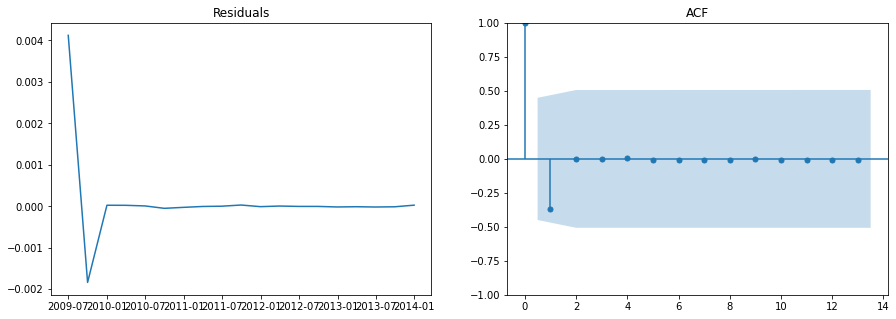


Test statistic for the residuals: -35.629
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



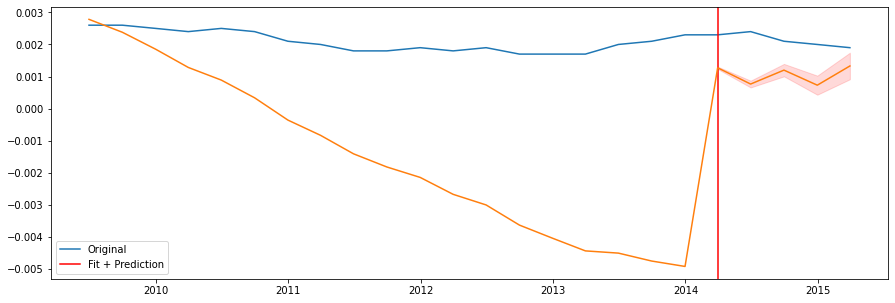

In [41]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_tree

In [42]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_tree,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-260.247, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-268.939, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-271.389, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-270.325, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-238.101, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-269.364, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-269.303, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-267.457, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-273.679, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-271.234, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-271.26

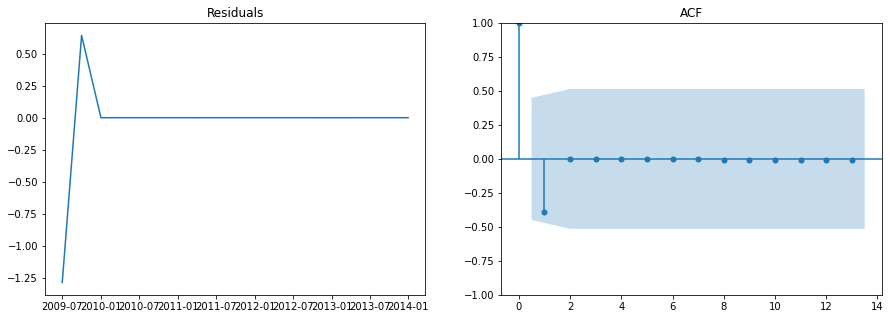


Test statistic for the residuals: -29.246
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



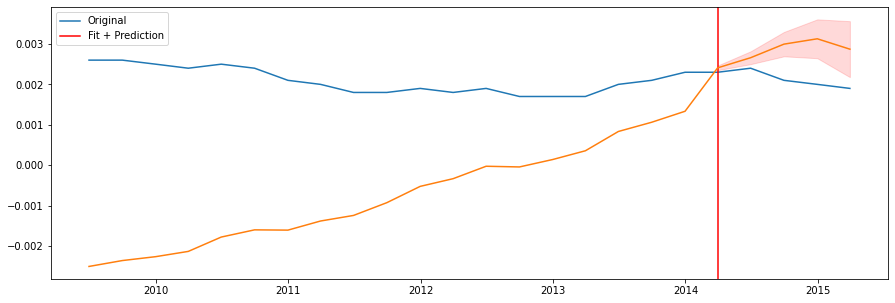

In [43]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_for

In [44]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_seq_for,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-215.790, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-230.826, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-231.407, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-233.410, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-199.999, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-230.092, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-226.393, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-183.880, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-235.453, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-232.224, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-227.89

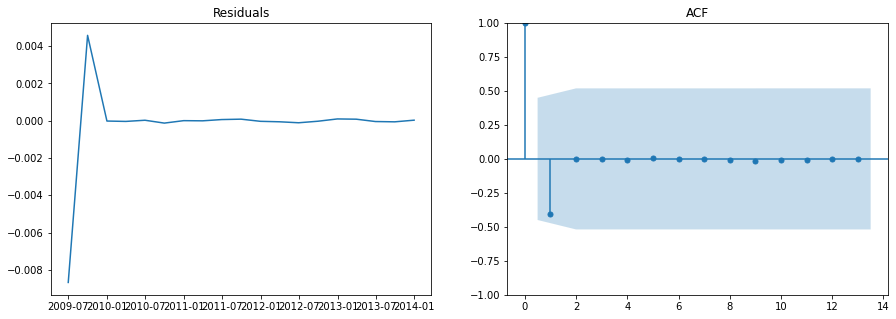


Test statistic for the residuals: -2.892
P-value for the residuals: 0.04628
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



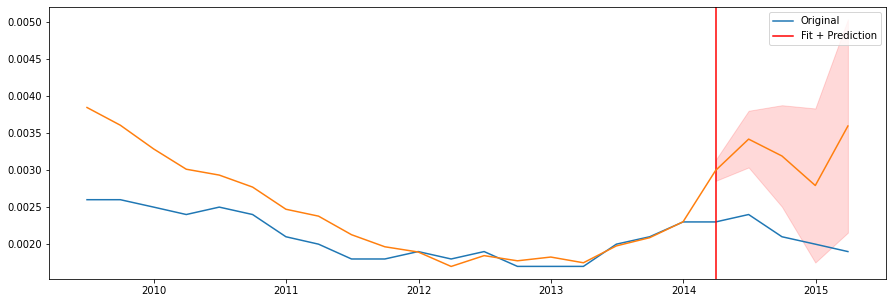

In [45]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_bac

In [46]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR2",col_used=cl.col_2_seq_bac,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff2: -4.628
P-value for the series y_diff2: 0.00011
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-307.350, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-315.350, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-313.350, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-313.350, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-317.350, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-311.350, Time=0.19 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.962 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 179.675

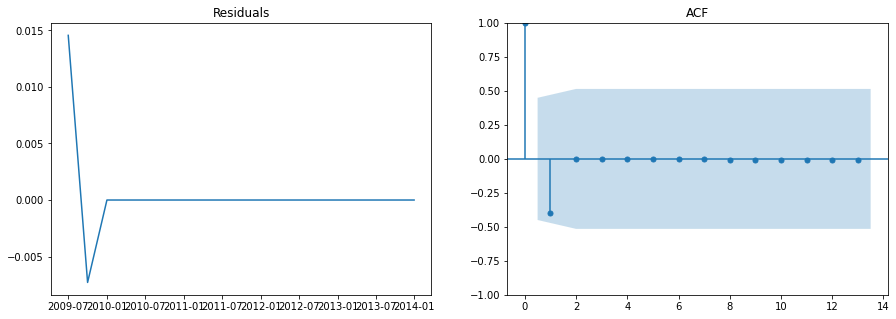


Test statistic for the residuals: -29.182
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 2.



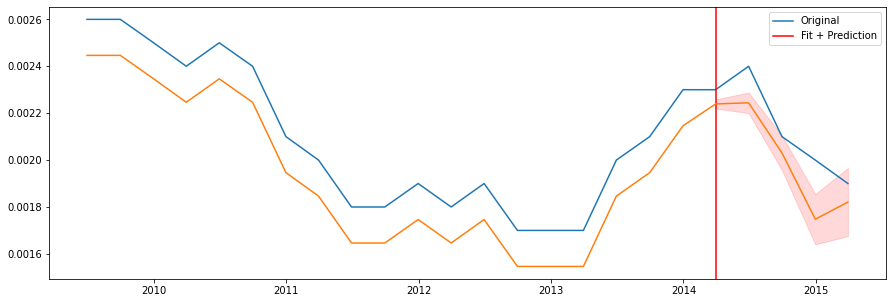

In [47]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

# Focus on chronique CHR8

In [48]:
start = 2

## With col_totale_corr

In [49]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_corr,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



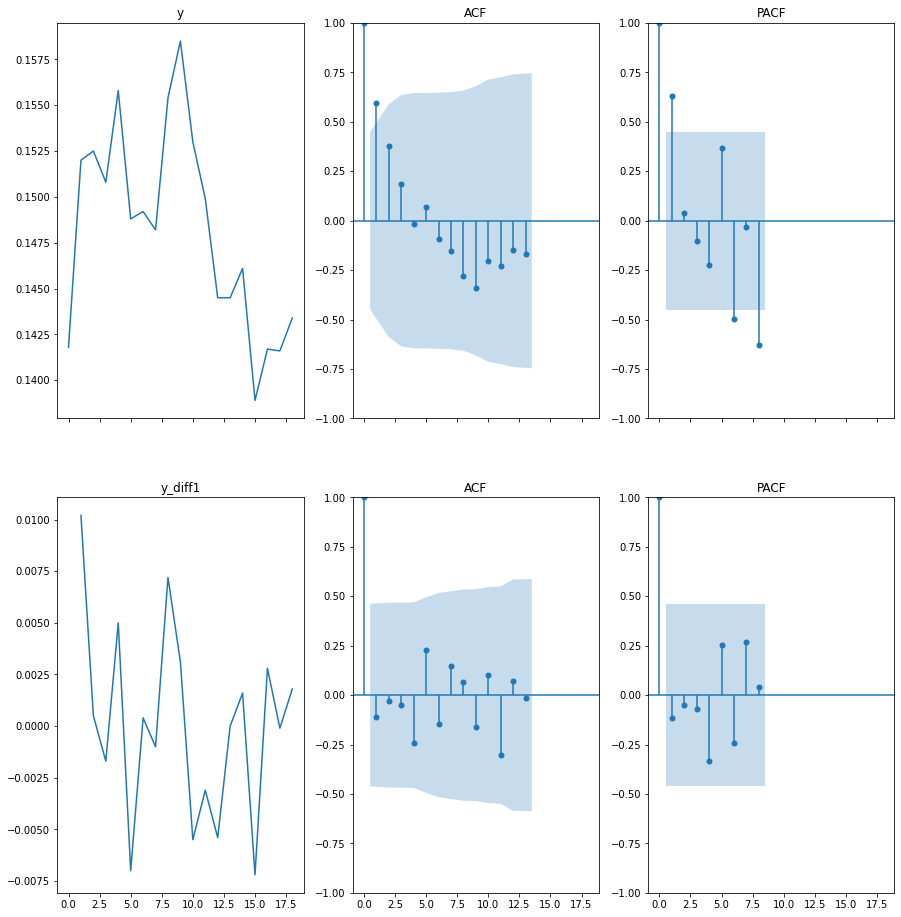

1

In [50]:
acf_pacf(y_train,alpha=0.05)


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-112.356, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-136.936, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.330, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-134.053, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.836, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-131.974, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.706 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  76.468
Dat

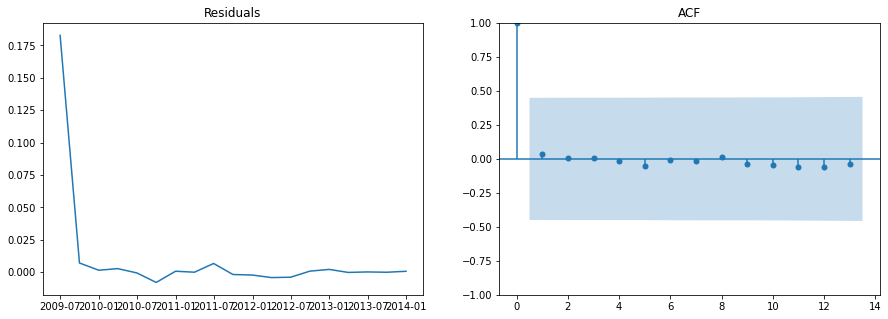


Test statistic for the residuals: -2.966
P-value for the residuals: 0.03822
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



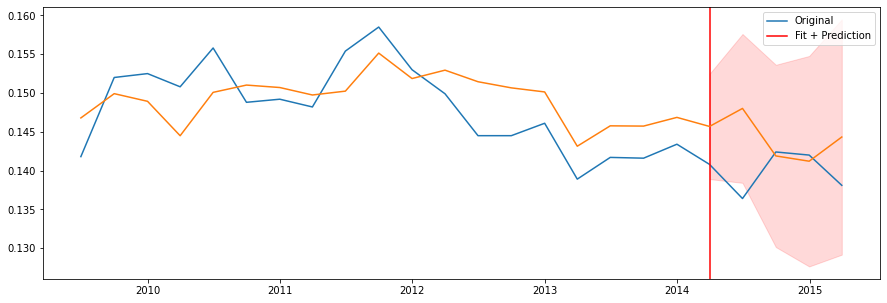

In [51]:
model = find_arimax_params(y_train,exog=X_train)
plot_arimax_fit(model,y_train,y_test=y_test,exog_train=X_train,exog_test=X_test)

## With col_totale_low_var

In [52]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_low_var,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-282.980, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-290.196, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-289.553, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.296, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-292.196, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-287.181, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.628 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 180.098
Dat

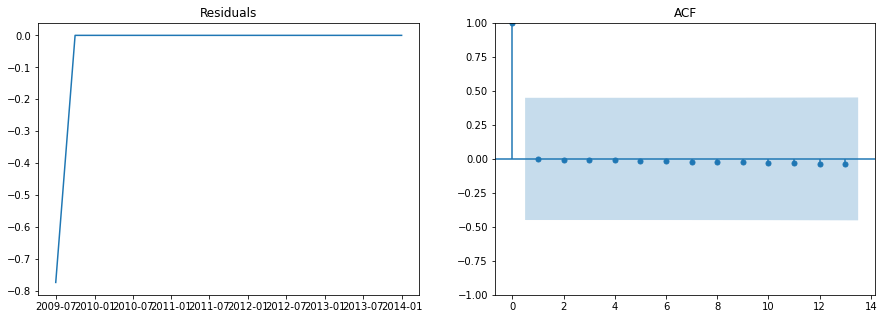


Test statistic for the residuals: -311997833993407.8
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



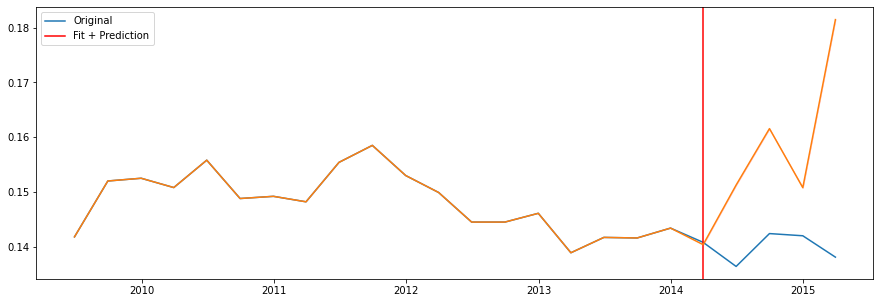

In [53]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_kbest

In [54]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_kbest,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-307.899, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-316.196, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-313.965, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-313.977, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-318.196, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-311.978, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.232 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 180.098
Dat

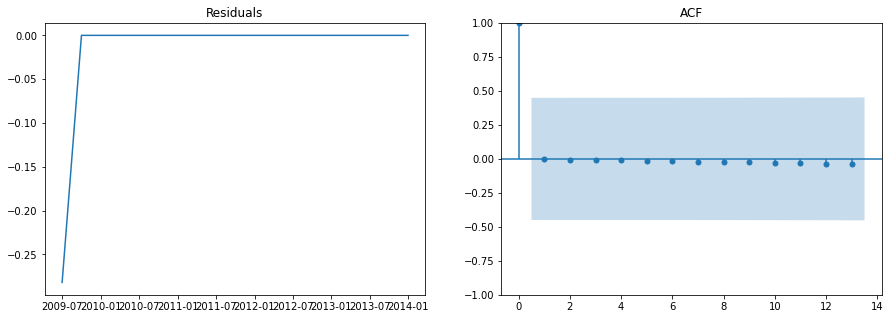


Test statistic for the residuals: -91869377662824.55
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



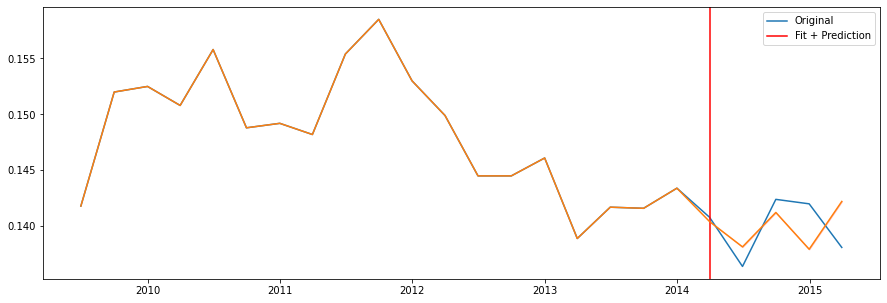

In [55]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_recur

In [56]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_recur,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-163.254, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-144.860, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-147.132, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-147.223, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-144.943, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-138.497, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-163.100, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-145.735, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-157.904, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-147.553, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-153.611, T

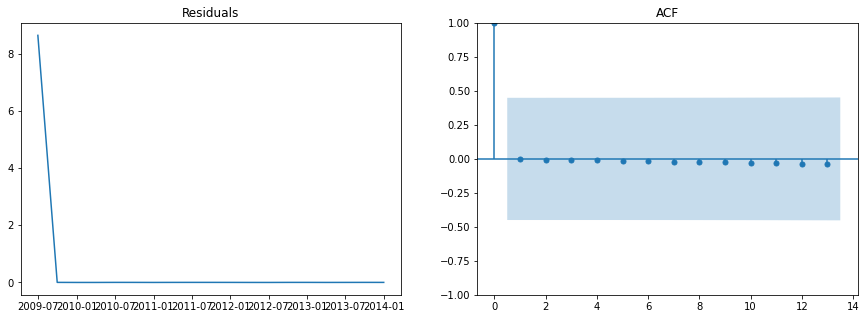


Test statistic for the residuals: -1.522
P-value for the residuals: 0.52264
The residuals are not stationary. We accept the hypothesis of a unit root.



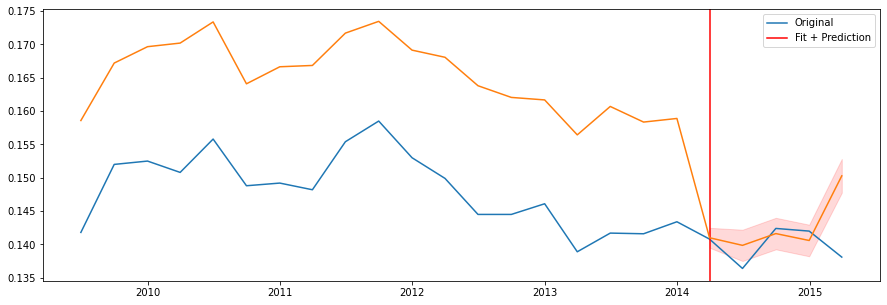

In [57]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_sfm

In [58]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_sfm,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-304.196, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-312.196, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-310.196, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-310.196, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-314.196, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-308.196, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.038 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 180.098
Dat

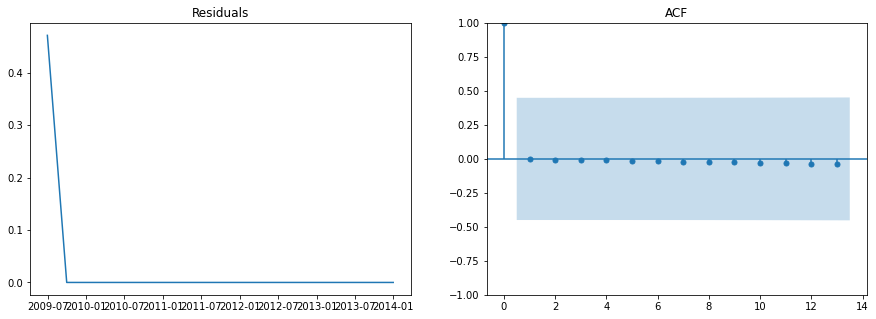


Test statistic for the residuals: -4203949735080020.0
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



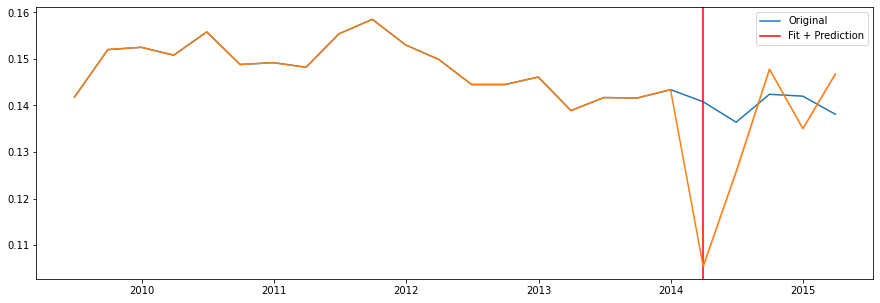

In [59]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_tree

In [60]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_tree,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-285.038, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-312.196, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-310.004, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-310.222, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-314.196, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-326.700, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-306.196, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-287.458, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-289.747, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-307.980, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-310.196, T

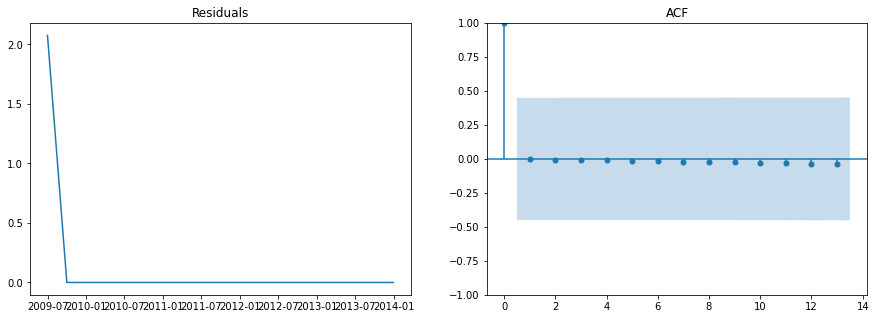


Test statistic for the residuals: -3.016
P-value for the residuals: 0.03343
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



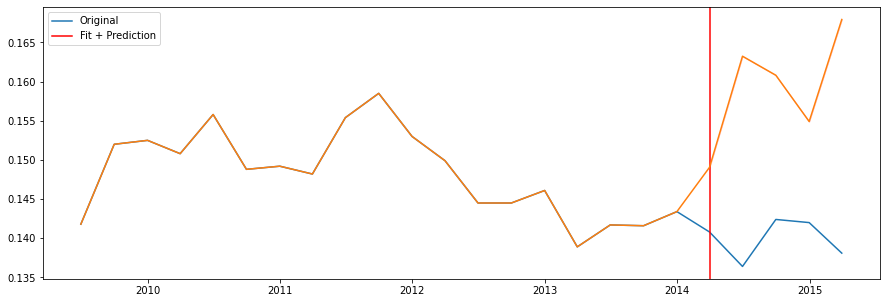

In [61]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_for

In [62]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_seq_for,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-308.196, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-316.196, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-313.995, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-313.873, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-318.196, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-311.919, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.958 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 180.098
Dat

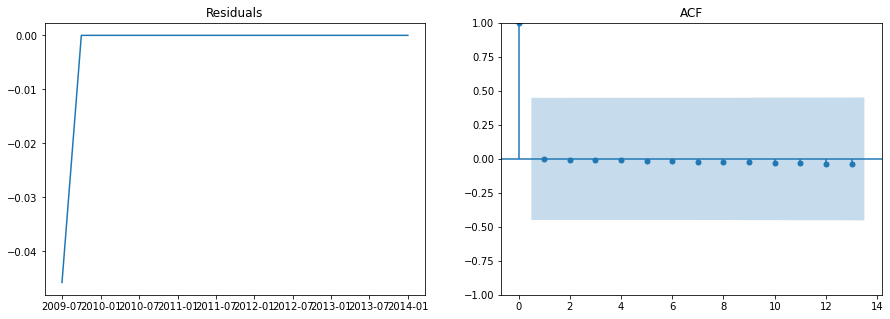


Test statistic for the residuals: -8319589665832.898
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



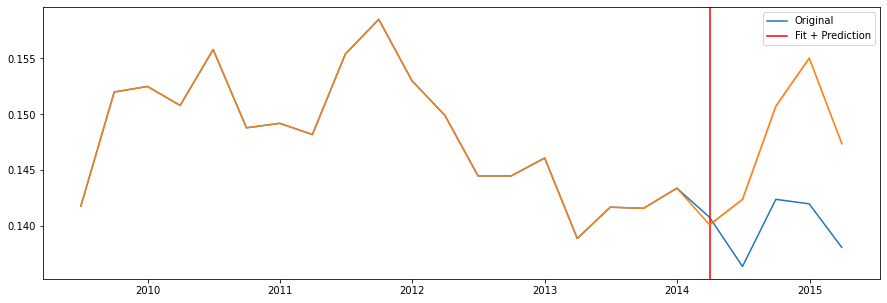

In [63]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)

## With col_totale_seq_bac

In [64]:
X_train, X_test, y_train, y_test = clean_data(data,start,b"CHR8",col_used=cl.col_8_seq_bac,split=0.2,norm='Not')
y_total = pd.concat([y_train,y_test])


Test statistic for the series y_diff1: -7.795
P-value for the series y_diff1: 0.0
The data is potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-307.550, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-316.196, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-334.381, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-313.547, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-318.196, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-332.266, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.241, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-330.208, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-336.378, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-334.236, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-335.098, Tim

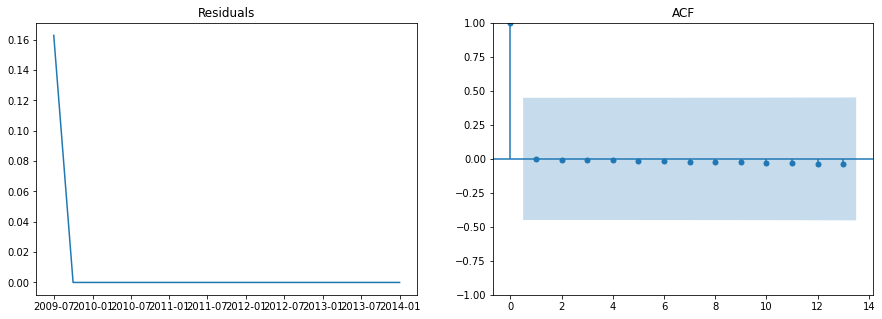


Test statistic for the residuals: -47439331199851.81
P-value for the residuals: 0.0
The residuals are potentially stationary. We reject the hypothesis of a unit root.
The level of differencing you need to use in order to have stationarity data is 1.



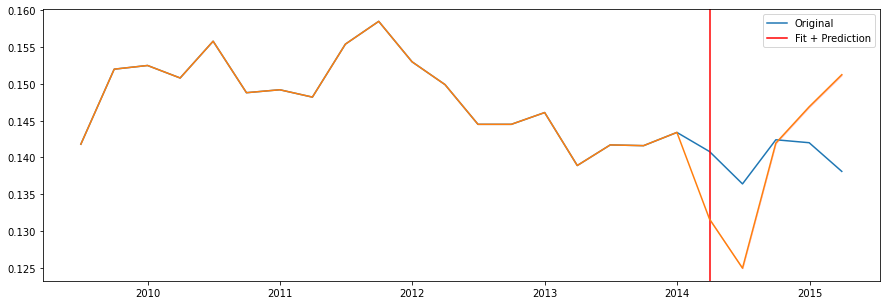

In [65]:
model = find_arimax_params(y_train,X_train)
plot_arimax_fit(model,y_train,y_test,X_train,X_test)